# 4 Detailed Preprocessing of Passive Data

This notebook shows the analysis of situational context using EMA and passive sensing data

1. **Load Data**: Load necessary data from pickle files.
2. **Preprocess EMA**:

In [1]:
import os
import sys
import regex as re
from tqdm import tqdm
from intervaltree import IntervalTree

%load_ext autoreload
%autoreload 2
import logging
# Configure logging
logging.basicConfig(level=logging.INFO)

# If your current working directory is the notebooks directory, use this:
notebook_dir = os.getcwd()  # current working directory
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src'))
sys.path.append(src_path)

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
import glob
import pickle
from IPython.display import Markdown
from server_config import datapath, preprocessed_path

import pandas as pd
import numpy as np
import datetime as dt
import EMA_Mapper
import gps_features

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from math import radians, cos, sin, asin, sqrt
import statistics  # Make sure this is imported
import hdbscan

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
import matplotlib.patches as mpatches
# Ensure matplotlib displays plots inline (if using Jupyter Notebook)
%matplotlib inline

sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set(style='whitegrid', context='talk', palette='deep')
%matplotlib inline
import plotly.express as px


In [2]:
backup_path = preprocessed_path + "/backup_data_passive_actual.feather"
df_backup = pd.read_feather(backup_path)

with open(preprocessed_path + '/ema_data.pkl', 'rb') as file:
    df_ema_framework = pickle.load(file)

with open(preprocessed_path + '/ema_content.pkl', 'rb') as file:
    df_ema_content = pickle.load(file)  

with open(preprocessed_path + '/monitoring_data.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)
    
with open(preprocessed_path + '/redcap_data.pkl', 'rb') as file:
    df_redcap = pickle.load(file)


In [3]:
# Configurations
# Check min. amount of EMA data available to map to passive data

#GPS data
speed_limit = 1.4
max_distance = 150 
kms_per_radian = 6371000
epsilon = 100/kms_per_radian
min_samples = 10
min_cluster_size = 20
min_nights_obs = 4
min_f_home = 0.5

# EMA
assessment_phase = [0] #1,2
min_num_daily = 4
min_days_data = 7


#Passive to EMA matching
timedelta_hours = 2
assess = 0

### Data overview

## Filter for participants with sufficient data

In [4]:
df_ema1 = df_ema_content.loc[df_ema_content.study.isin([24,25])] # first assessment phase
df_ema1 = df_ema1.loc[df_ema1["n_quest"] >= min_num_daily]
df_ema1["n_days_min"] = df_ema1.groupby("customer")['quest_complete_day'].transform("nunique")
df_ema1 = df_ema1.loc[df_ema1.n_days_min >= min_days_data]
df_ema1_customers = df_ema1.customer.unique().tolist()


In [5]:
df_ema1.customer.nunique()

208

### Analyze missingness

In [6]:
# List of customers
customers = df_ema1['customer'].unique()

# List of days (assuming absolute_day_index starts from 1)
days = range(1, df_ema1['absolute_day_index'].max() + 1)

# List of expected quest numbers per day (e.g., quest_nr from 1 to 8)
expected_quests = [1, 2, 3, 4, 5, 6, 7, 8]  # Adjust based on your actual quest numbers

# Create a MultiIndex of all combinations
index = pd.MultiIndex.from_product([customers, days, expected_quests], names=['customer', 'absolute_day_index', 'quest_nr'])

# Create a DataFrame representing the complete schedule
df_expected = pd.DataFrame(index=index).reset_index()

In [7]:
# Select relevant columns from completed quests
df_completed = df_ema1[['customer', 'absolute_day_index', 'quest_nr']].drop_duplicates()

# Merge expected and completed quests
df_quests = pd.merge(df_expected, df_completed, on=['customer', 'absolute_day_index', 'quest_nr'], how='left', indicator=True)

# '_merge' column will indicate if the quest was completed ('both') or missing ('left_only')
df_quests['quest_status'] = np.where(df_quests['_merge'] == 'both', 'Completed', 'Missing')
df_quests.drop(columns=['_merge'], inplace=True)


In [8]:
# Extract the hour from 'quest_create'
df_ema_content['quest_create_hour'] = df_ema_content['quest_create'].dt.hour

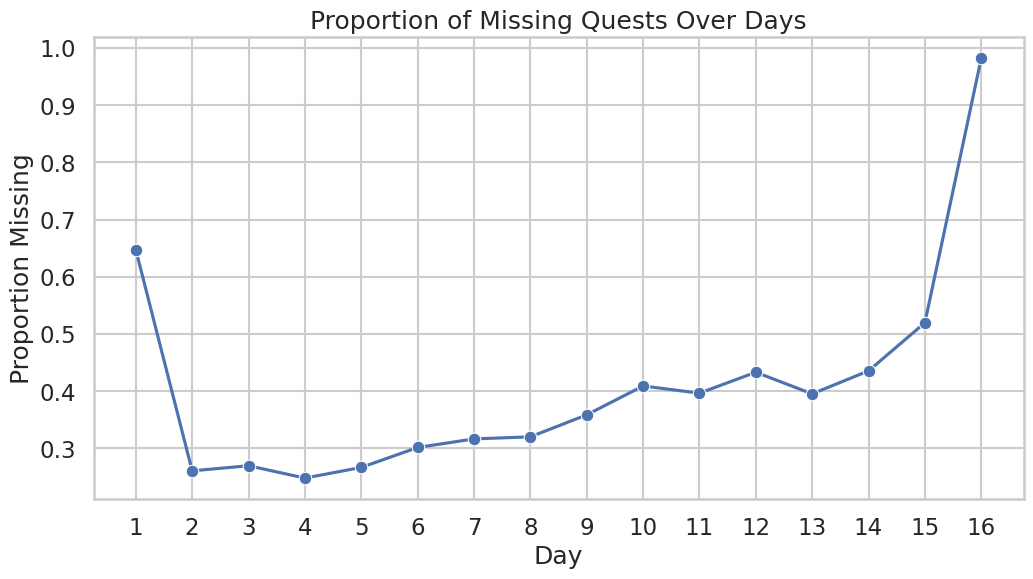

In [9]:
# Calculate the proportion of missing quests per day
missingness_by_day = df_quests.groupby('absolute_day_index')['quest_status'].apply(lambda x: (x == 'Missing').mean()).reset_index()

# Plotting missingness over days
plt.figure(figsize=(12, 6))
sns.lineplot(x='absolute_day_index', y='quest_status', data=missingness_by_day, marker='o')
plt.title('Proportion of Missing Quests Over Days')
plt.xlabel('Day')
plt.ylabel('Proportion Missing')
plt.xticks(range(1, df_quests['absolute_day_index'].max() + 1))
plt.grid(True)
plt.show()


## 1. Prepare passive features

In [10]:
df_pass_act = df_backup.copy()

In [11]:
df_pass_act.startTimestamp.max()

Timestamp('2024-12-23 01:07:44.060000')

In [12]:
# Only keep data that were collected during the first assessment phase
df_pass_act_base = df_pass_act[df_pass_act.startTimestamp <= (df_pass_act.ema_base_end + pd.Timedelta(days=1))]

In [13]:
df_pass_act_base = df_pass_act_base.loc[df_pass_act_base.customer.isin(df_ema1_customers)]

In [14]:
df_pass_act_base.customer.nunique()

207

In [15]:
df_pass_act_base['Heart_Rate_data_coverage_per'].replace([np.inf, -np.inf], np.nan, inplace=True)


/tmp/ipykernel_642979/2028720565.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pass_act_base['Heart_Rate_data_coverage_per'].replace([np.inf, -np.inf], np.nan, inplace=True)


### 1.1 Calculate GPS features

In [16]:
df_pass_act_loc =df_pass_act_base[df_pass_act_base.type.isin(["Latitude", "Longitude"])][["customer", "startTimestamp", "type", "doubleValue"]]

In [17]:
df_loc = df_pass_act_loc.pivot_table(
    index=["customer", "startTimestamp"],
    columns="type",
    values=["doubleValue"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_loc.columns = ['_'.join(col).strip() for col in df_loc.columns.values]

df_loc = df_loc.rename_axis(None, axis=1).reset_index()

# Rename the columns for clarity
df_loc = df_loc.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
})

In [18]:
df_loc.customer.nunique()

196

In [19]:
# Count the number of rows per customer
customer_counts = df_loc['customer'].value_counts()

# Get a description of the distribution
distribution_description = customer_counts.describe()
print("Description of the distribution of number of rows per customer:")
print(distribution_description)

# Display percentiles
percentiles = customer_counts.quantile([i / 20 for i in range(1, 21)])
print("\nPercentiles:")
print(percentiles)

# Find minimum threshold for data inclusion with a floor of 0
threshold = max(0, customer_counts.mean() - customer_counts.std())
print(f"\nMinimum threshold for inclusion: {threshold}")

Description of the distribution of number of rows per customer:
count      196.000000
mean      4716.459184
std       6301.537251
min          2.000000
25%        744.500000
50%       1561.000000
75%       6962.000000
max      39632.000000
Name: count, dtype: float64

Percentiles:
0.05       89.25
0.10      222.00
0.15      437.00
0.20      616.00
0.25      744.50
0.30      895.50
0.35     1072.00
0.40     1253.00
0.45     1400.50
0.50     1561.00
0.55     1905.00
0.60     2503.00
0.65     3240.75
0.70     4419.50
0.75     6962.00
0.80     9304.00
0.85    12026.75
0.90    14083.00
0.95    16882.00
1.00    39632.00
Name: count, dtype: float64

Minimum threshold for inclusion: 0


In [20]:
# Example usage with HDBSCAN and normalized min_samples:
extractor = gps_features.HomeClusterExtractor(df_loc, speed_limit=speed_limit, max_distance=max_distance, epsilon=epsilon, min_samples=min_samples, 
                                 min_nights_obs = min_nights_obs, min_f_home=min_f_home, clustering_method='dbscan', 
                                 normalize_min_samples=False, min_data_points=87)
result = extractor.run()


INFO:root:Data quality check: 186 customers with sufficient data retained.
INFO:root:Customers with no home after time-based method: 22
INFO:root:Fallback home clusters assigned: 22


In [21]:
# 20 customers not enough GPS data (i.e. less than 50 data points, so that no home cluster could be computed 


In [22]:
home_clusters_red = result[["customer", "startTimestamp", "at_home","transition", "distance", "stationary","time_diff", "speed", "clusterID", "homeID" ]]

In [23]:
gps_customer_list = home_clusters_red.customer.unique().tolist()

In [24]:
df_pass_act_base['type'].value_counts()


type
Longitude                      928786
Latitude                       928785
CoveredDistance                586909
Steps                          586909
ActiveBurnedCalories           576657
HeartRate                      575391
RawECGVoltage                  137554
ActivityType                    68259
SleepInBedBinary                37452
SleepStateBinary                34067
SleepBinary                     34067
SleepLightBinary                31044
SleepDeepBinary                 25061
ElevationGain                   10643
SleepAwakeBinary                 8910
ActivityTypeDetail1              8018
ActivityTypeDetail2              8012
FloorsClimbed                    6720
WalkBinary                       6551
SPO2                             5601
AtrialFibrillationDetection      1497
BikeBinary                       1181
ActiveBinary                      352
RunBinary                         109
Weight                             64
FatMass                            22
FatFree

## 2. Prepare EMA data

In [25]:
df_ema_udi = df_ema_content[["customer", "createdAt_day", "quest_create", "unique_day_id", "assess"]]

In [26]:
df_ema_udi = df_ema_udi.loc[df_ema_udi.customer.isin(gps_customer_list)]

In [27]:
df_ema_udi.customer.nunique()

186

In [28]:
# Group by customer and unique_day_id and calculate the minimum quest_create
df_min_quest = df_ema_udi.groupby(['customer', 'unique_day_id'])['quest_create'].min().reset_index()

# Rename the column to sensor_block_end
df_min_quest.rename(columns={'quest_create': 'sensor_block_end'}, inplace=True)

# Merge the minimum quest_create back to the original DataFrame
df_ema_udi = pd.merge(df_ema_udi, df_min_quest, on=['customer', 'unique_day_id'], how='left')

# Create the sensor_block_start column, which is 2 hours before quest_create
df_ema_udi.drop(columns=['quest_create'], inplace=True)
df_ema_udi = df_ema_udi.drop_duplicates()

In [29]:
# prepare mapping of passing data by creating blocks

df_ema_udi['sensor_block_start'] = df_ema_udi['sensor_block_end'] - pd.Timedelta(hours=2)


In [30]:
# Only include first assessment phase

df_ema_udi_base = df_ema_udi.loc[df_ema_udi.assess == 0]

In [31]:
df_ema_udi_base = df_ema_udi_base.copy()
df_ema_udi_base["unique_blocks"] = df_ema_udi_base.customer + df_ema_udi_base.unique_day_id

In [32]:
df_ema_udi_merged = pd.merge(df_ema_udi_base, df_redcap, on="customer")

## 3. Merge EMA to passive data

In [33]:
# Ensure 'customer' columns are strings and stripped of whitespace
df_ema_udi_merged['customer'] = df_ema_udi_merged['customer'].astype(str).str.strip()
df_pass_act_base['customer'] = df_pass_act_base['customer'].astype(str).str.strip()
home_clusters_red['customer'] = home_clusters_red['customer'].astype(str).str.strip()

/tmp/ipykernel_642979/431454365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_clusters_red['customer'] = home_clusters_red['customer'].astype(str).str.strip()


In [ ]:
# Step 1: Initialize the EMAMapper
ema_mapper = EMA_Mapper.EMAMapper(df_ema_udi_merged, df_pass_act_base, home_clusters_red)

# Step 2: Run the mappings
ema_mapper.run_mappings()

# Step 3: Retrieve the enriched EMA DataFrame
df_ema_enriched = ema_mapper.get_result()

Heart Rate Data Cleaning Summary:
Initial entries: 575391
Removed due to non-numeric values: 0
Removed due to thresholds: 0
Removed due to exceeding change rate threshold: 5796
Total entries removed: 5796
Remaining entries: 569595
Step Data Cleaning Summary:
Initial entries: 586909
Removed due to non-numeric values: 0
Removed due to negative steps: 0
Removed due to zero or negative duration: 0
Removed due to exceeding steps per minute threshold: 412
Total entries removed: 412
Remaining entries: 586497


/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0
/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

ActiveBurnedCalories Data Cleaning Summary:
Initial entries: 576657
Remaining entries: 576657
Entries removed: 0


/home/leha18/tiki_code/src/EMA_Mapper.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ema_batch['key'] = 0


In [ ]:
df_ema_enriched.shape

In [ ]:
df_ema_enriched.customer.nunique()

In [ ]:
import pandas as pd

def summarize_missing_data(
    df,
    feature_group_pa,
    feature_group_gps,
    feature_group_hr,
    columns_to_check,
    top_n_pairs=5
):
    """
    Summarize -1 missing data for exactly five groups:
      1) PA (Physical Activity)
      2) GPS
      3) HR (Heart Rate)
      4) n_steps (single column)
      5) calories_burned (single column)

    Returns
    -------
    group_missing_df : pd.DataFrame
        DataFrame with the same index as `df` and exactly these columns:
        ["PA", "GPS", "HR", "n_steps", "calories_burned"] (some may be all 0 if not found).
        Each cell is 1 if that group is missing for that row, else 0.
    
    Notes
    -----
    - Any columns not in `columns_to_check` or not in the DataFrame are ignored.
    - The function also prints the usual missing-data summaries, but importantly it
      returns `group_missing_df` for further analysis by other functions.
    """
    # Only consider columns actually in df AND in columns_to_check
    relevant_cols = set(df.columns).intersection(columns_to_check)

    # Exactly 5 groups, filtering out columns not in relevant_cols
    group_dict = {
        "PA": [c for c in feature_group_pa if c in relevant_cols],
        "GPS": [c for c in feature_group_gps if c in relevant_cols],
        "HR": [c for c in feature_group_hr if c in relevant_cols],
        "n_steps": ["n_steps"] if "n_steps" in relevant_cols else [],
        "calories_burned": ["calories_burned"] if "calories_burned" in relevant_cols else []
    }

    print("=== Missing Data Analysis (Restricted to 'columns_to_check' and 5 Groups) ===\n")
    total_rows = len(df)

    # -------------------------------------------------------------------------
    # A) Group-wise summary of missing data
    # -------------------------------------------------------------------------
    for group_name, cols in group_dict.items():
        if not cols:
            # If a group has zero columns (e.g. "calories_burned" not in relevant_cols), skip.
            continue

        print(f"Group: {group_name} (contains {len(cols)} column(s))")
        print("-" * 50)
        for col in cols:
            missing_count = (df[col] == -1).sum()
            pct_missing = (missing_count / total_rows) * 100
            print(f"  {col}: {missing_count} missing (-1)  [{pct_missing:.2f}%]")
        print()

    # -------------------------------------------------------------------------
    # B) Within-group co-occurrence (column vs. column)
    # -------------------------------------------------------------------------
    for group_name, cols in group_dict.items():
        if len(cols) <= 1:
            continue  # No pairwise co-occurrence with 0 or 1 columns

        print(f"Co-occurrence within group '{group_name}'")
        print("-" * 50)

        # Build a binary matrix: 1 if row is -1 in that col, else 0
        missing_matrix = (df[cols] == -1).astype(int)

        # Dot product => co-occurrence counts
        co_occ = missing_matrix.T.dot(missing_matrix)
        co_occ_df = pd.DataFrame(co_occ, index=cols, columns=cols)

        # Collect upper-triangle pairs
        pairs = []
        n_cols = len(cols)
        for i in range(n_cols):
            for j in range(i + 1, n_cols):
                col_i = cols[i]
                col_j = cols[j]
                count_ij = co_occ_df.iloc[i, j]
                if count_ij > 0:
                    pairs.append(((col_i, col_j), count_ij))

        # Sort pairs by descending co-occurrence
        pairs.sort(key=lambda x: x[1], reverse=True)

        top_n_to_show = min(top_n_pairs, len(pairs))
        if top_n_to_show > 0:
            print(f"  Top {top_n_to_show} missing-together pairs:")
            for rank, ((c1, c2), count) in enumerate(pairs[:top_n_to_show], start=1):
                print(f"    {rank}. {c1} & {c2} -> {count} rows")
        else:
            print("  No missing co-occurrences found.")
        print()

    # -------------------------------------------------------------------------
    # C) Across-group co-occurrence (group vs. group)
    # -------------------------------------------------------------------------
    group_names = list(group_dict.keys())

    # Build a DataFrame with 1 if ANY column in that group is -1 in a row
    group_missing_df = pd.DataFrame(index=df.index, columns=group_names, dtype=int)
    for g in group_names:
        cols_g = group_dict[g]
        if not cols_g:
            group_missing_df[g] = 0
        else:
            group_missing_df[g] = (df[cols_g] == -1).any(axis=1).astype(int)

    # Dot product for group-level co-occurrences
    co_occ_groups = group_missing_df.T.dot(group_missing_df)
    co_occ_groups_df = pd.DataFrame(co_occ_groups, index=group_names, columns=group_names)

    print("Co-occurrence Across Groups (Any Missing in a Group):")
    print("-" * 50)

    # Print how many rows have missing data for each group
    for g in group_names:
        grp_missing_count = group_missing_df[g].sum()
        pct_grp_missing = (grp_missing_count / total_rows) * 100
        print(f"  {g} missing in {grp_missing_count} row(s) [{pct_grp_missing:.2f}%]")

    # Pairwise group co-occurrence
    print("\nPairwise Group Co-occurrence:")
    pairs_grp = []
    for i in range(len(group_names)):
        for j in range(i + 1, len(group_names)):
            g_i = group_names[i]
            g_j = group_names[j]
            val = co_occ_groups_df.loc[g_i, g_j]
            if val > 0:
                pairs_grp.append(((g_i, g_j), val))

    pairs_grp.sort(key=lambda x: x[1], reverse=True)

    if pairs_grp:
        print("  All group pairs missing together (sorted by frequency):")
        for rank, ((g1, g2), cnt) in enumerate(pairs_grp, start=1):
            print(f"    {rank}. {g1} & {g2} -> {cnt} rows")
    else:
        print("  No group-level co-occurrences found.")
    print()

    # -------------------------------------------------------------------------
    # D) Exactly k groups missing + which combos are missing together
    # -------------------------------------------------------------------------
    row_sums = group_missing_df.sum(axis=1)
    max_groups = len(group_names)

    print("=== How Many Rows Have Missing Data in Exactly k Groups? ===")
    for k in range(1, max_groups + 1):
        count_k = (row_sums == k).sum()
        pct_k = (count_k / total_rows) * 100
        print(f"  Exactly {k} group(s) missing: {count_k} rows [{pct_k:.2f}%]")
    print()

    # Identify the group combos for each row
    def get_missing_groups(row):
        return "_".join([g for g in group_names if row[g] == 1])

    patterns = group_missing_df.apply(get_missing_groups, axis=1)
    pattern_counts = patterns.value_counts()

    # Exclude the empty pattern (no groups missing)
    pattern_counts = pattern_counts.drop("", errors="ignore")

    print("=== Missing-Group Patterns (Which groups are missing together) ===")
    for combo, cnt in pattern_counts.items():
        pct_combo = (cnt / total_rows) * 100
        print(f"  Groups [{combo}] -> {cnt} rows [{pct_combo:.2f}%]")

    print("\n=== End of Missing Data Analysis ===")

    # -------------------------------------------------------
    # Return group_missing_df for further analysis
    # -------------------------------------------------------
    return group_missing_df


In [ ]:
def create_special_dfs(df, group_missing_df):
    """
    Create dataframes for two specific scenarios:
      1) Rows where ALL ScanWatch features are missing
         (i.e. PA, HR, n_steps, calories_burned).
      2) Rows where GPS is missing, but n_steps is NOT missing.

    Parameters
    ----------
    df : pd.DataFrame
        The original dataframe (same index as `group_missing_df`).
    group_missing_df : pd.DataFrame
        A 0/1 indicator DataFrame of shape (num_rows, 5 groups).
        The columns are expected to be ["PA", "GPS", "HR", "n_steps", "calories_burned"].

    Returns
    -------
    df_all_scanwatch_missing : pd.DataFrame
        Subset of rows where all scanwatch features are missing.
    df_gps_missing_steps_not : pd.DataFrame
        Subset of rows where GPS is missing, but n_steps is not missing.
    """

    # 1) Rows where ALL ScanWatch features are missing (PA, HR, n_steps, calories_burned).
    scanwatch_groups = ["PA", "HR", "n_steps", "calories_burned"]
    # Keep only groups that exist in the DataFrame:
    existing_scanwatch_groups = [g for g in scanwatch_groups if g in group_missing_df.columns]

    if existing_scanwatch_groups:
        all_scanwatch_missing_mask = (
            group_missing_df[existing_scanwatch_groups].sum(axis=1) == len(existing_scanwatch_groups)
        )
        df_all_scanwatch_missing = df.loc[all_scanwatch_missing_mask]
    else:
        df_all_scanwatch_missing = pd.DataFrame()

    # 2) Rows where GPS is missing, but n_steps is NOT missing
    if "GPS" in group_missing_df.columns and "n_steps" in group_missing_df.columns:
        gps_missing = group_missing_df["GPS"] == 1
        n_steps_missing = group_missing_df["n_steps"] == 1
        gps_missing_steps_not_mask = gps_missing & (~n_steps_missing)
        df_gps_missing_steps_not = df.loc[gps_missing_steps_not_mask]
    else:
        df_gps_missing_steps_not = pd.DataFrame()

    return df_all_scanwatch_missing, df_gps_missing_steps_not


In [ ]:
feature_group_pa = [
    "activity_102_minutes",
    "activity_103_minutes",
    "activity_104_minutes",
    "activity_105_minutes",
    "activity_106_minutes",
    "activity_107_minutes"
]

feature_group_gps = [
    "n_GPS",
    "total_distance_km",
    "at_home_minute",
    "time_in_transition_minutes",
    "time_stationary_minutes"
]

feature_group_hr = [
    "hr_zone_resting",
    "hr_zone_moderate",
    "hr_zone_vigorous",
    "hr_mean",
    "hr_min",
    "hr_max",
    "hr_std",
    "hr_median",
    "range_heartrate",
    "iqr_heartrate", "HRR", "hr_rest"
]

columns_to_check = ['HR_max', 'HR_rest',
       'HRR', 'hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hr_median',
       'range_heartrate', 'iqr_heartrate', 'hr_zone_resting',
       'hr_zone_moderate', 'hr_zone_vigorous', 'n_steps',
       'total_activeburnedcalories', 'n_GPS',
       'total_distance_km', 'at_home_minute', 'time_in_transition_minutes',
       'time_stationary_minutes',
       'activity_102_minutes', 'activity_103_minutes', 'activity_104_minutes',
       'activity_105_minutes', 'activity_106_minutes', 'activity_107_minutes']

In [ ]:
df_ema_enriched.customer.nunique()

In [ ]:
group_missing_df = summarize_missing_data(
    df=df_ema_enriched,
    feature_group_pa=feature_group_pa,
    feature_group_gps=feature_group_gps,
    feature_group_hr=feature_group_hr,
    columns_to_check=columns_to_check,
    top_n_pairs=10

)# 2) Create the special dataframes
df_all_scanwatch, df_gps_missing_steps_not = create_special_dfs(df_ema_enriched, group_missing_df)

# Now you can investigate or exclude these subsets:
print(f"Rows with ALL ScanWatch features missing: {len(df_all_scanwatch)}")
print(f"Rows with GPS missing but steps not missing: {len(df_gps_missing_steps_not)}")

In [ ]:
df_gps_200 = df_gps_missing_steps_not.loc[df_gps_missing_steps_not.n_steps > 200][["n_steps", "customer"]]

In [ ]:
# 1) Count how many entries each customer has in df_gps
gps_count_df = (
    df_gps_200
    .groupby('customer')
    .size()  # or count()
    .reset_index(name='gps_count')
)

# 2) Count how many entries each customer has in the original df
total_count_df = (
    df_ema_enriched
    .groupby('customer')
    .size()
    .reset_index(name='total_count')
)

# 3) Merge them together on 'customer'
summary_df = pd.merge(total_count_df, gps_count_df, on='customer', how='left')

# If a customer doesn’t appear in df_gps at all, 'gps_count' will be NaN
summary_df['gps_count'] = summary_df['gps_count'].fillna(0).astype(int)

# 4) Calculate the proportion
summary_df['proportion'] = summary_df['gps_count'] / summary_df['total_count']
# 5) Sort in descending order by 'proportion'
summary_df.sort_values(by='proportion', ascending=False, inplace=True)

In [ ]:
summary_df.loc[summary_df.proportion > 0.5].count()

In [ ]:
# covered distance just combi of steps, height, weight..

In [ ]:
with open(preprocessed_path + '/map_ema_passive.pkl', 'wb') as file:
    pickle.dump(df_ema_with_at_home, file)